In [6]:
import colorama
from colorama import Fore
colorama.init(autoreset=True)
import random
import matplotlib.pyplot as plt

def convert_ternary(feedback:list) -> int:
    """
    Parameters
    ----------
    feedback : list
        Contains 05 elements, which can be 0, 1, or 2, denoting a feedback pattern.
    -------
    Return 
    ------
    int
        Base 10 representation of pattern.
    """
    return sum([feedback[i]*3**(4-i) for i in range(5)])

def get_feedback(guess:str,answer:str) ->list:
    """
    Parameters
    ----------
    guess : str
        Five-letter guess.
    answer : str
        Five-letter correct answer.
    -------
    Return 
    ------
    feedback : list
        Contains 05 elements, which can be 0, 1, or 2, denoting a feedback pattern.
    """
    #convert string to list
    temp = list(answer)
    answer = temp
    temp = list(guess)
    guess = temp
    
    #initialize
    feedback = ['']*5
    #isolate correctly placed letters
    for i in range(5):
        if guess[i] == answer[i]:
            feedback[i] = 2
            answer[i] = ''
            guess[i] = ''
    
    #isolate wrongly placed letters
    for i in range(5):
        if guess[i] == '': continue
        elif guess[i] in answer:
            feedback[i] = 1
            answer[answer.index(guess[i])] = ''
            guess[i] = ''
        else:
            feedback[i] = 0
    return feedback

def reduce_list(guess:str,feedback:list,word_list:list) ->list:
    '''
    Parameters
    ----------
    guess: the word we guessed in this step
    feedback: the pattern given by game
    word_list: allowed list in the first step and the reduced list in the next steps
    ----------
    Return 
    ------
    the reduced word list which could be possible answers or allowed guesses in hardmode and possible answers in easymode
    
    '''
    return [word for word in word_list if get_feedback(guess,word)==feedback]


def generate_ternary(n:int) ->list:
    """
    Parameters
    ----------
    n: An integer, indicating length of number.
    
    ----------
    Return 
    ------
    res: List of all ternary numbers of length n.
    """
    res = list()
    s = [0] * n
    while True:
        temp = s[:]
        res.append(temp)
        i = n-1
        while i >= 0:
            if s[i] == 2:
                i -= 1
            else:
                break
        if i == -1:
            break
        else:
            temp = s[i]
            s[i] = temp + 1
            for j in range(i+1,n):
                s[j] = 0
    return res
def REDUCE_LIST(guess:list,real_feedback:list,still_valid_words:list,mode={0,1,2}):
    """
    Parameters
    ----------
    still_valid_words : list
        Contains words still possible as an answer.
    guess : str
        Five-letter guess.
    real_feedback : list
        Contains 05 elements, which can be 0, 1, or 2, denoting a feedback pattern.
    mode: set
        One of the seven filters: {0}, {1}, {2}, {0,1}, {0,2}, {1,2}, {0,1,2}

    Returns
    -------
    updated_allowed_words : list
        Updates allowed_words by retaining only words fitting the actual feedback.
    """
    n = 0
    accepted_feedback = real_feedback[:]
    
    #letter_feedback works like a mould, designated colors are retained, other positions can be changed arbitrary
    for i, letter_feedback in enumerate(real_feedback):
        if letter_feedback not in mode:
            n += 1
            accepted_feedback[i] = None
    
    accepted_feedbacks_enumerated = list()
    
    #generate_ternary(n) lists all combinations available to fill in the arbitrary positions
    for insertion in generate_ternary(n):
        temp = accepted_feedback[:]
        for i, letter_feedback in enumerate(temp):
            if letter_feedback == None:
                temp[i] = insertion.pop(0) #traverse left to right, popping a combination to fill in the mould
        accepted_feedbacks_enumerated.append(convert_ternary(temp))
    updated_allowed_words = list()
    for word in still_valid_words:
        feedback_enumerated = convert_ternary(get_feedback(guess,word))
        if feedback_enumerated in accepted_feedbacks_enumerated:
            updated_allowed_words.append(word)
    return updated_allowed_words

def check_win(feedback:list)->list:
    """
    Parameters
    ----------
    feedback : list
        Contains 05 elements, which can be 0, 1, or 2.
    ---------
    Return
    -------
    win : bool
        Becomes True when feedback is a list of 05 2's.
    """
    return feedback==[2]*5

def TestModel(solution_for_test,test_list:list,RANDOM=False) -> tuple:
    '''
    Parameter
    ----------
    solution: The function return the number of step to guess a specific answer \n
    test_list: The list of answers for testing
    RANDOM: False, answer is chosen randomly and True, answer is chosen sequentially from the test_list
    ----------
    Return: The bar chart with x(number of guesses needed) and y (number of plays having x guesses) \n
                  The tupple of winrate and average score'''
    import time
    t1=time.time()
    #Compute some vital factor: number of plays having x guesses, win rate, average score of 2,3k plays   
    xMax=20 # may be posituve infinity number
    yMax=0
    lst=[0]*xMax
    N=len(test_list)# list contains number of plays having x guesses
    for word in test_list:
        if not RANDOM:
            answer=word
        elif RANDOM:
            answer=random.choice(test_list)
        NumberOfGuessesNeeded=len(solution_for_test(answer))
        lst[NumberOfGuessesNeeded]=lst[NumberOfGuessesNeeded]+1
    winrate=sum(lst[1:7])/N*100
    average=sum([i*lst[i] for i in range(1,xMax)]) / N

    #VISUALIZATION
    for i in range(1,xMax):
        if lst[i] >=yMax: # because yMax always in (1,6)
            yMax=lst[i]
        if lst[i]==0 and i>6:
            xMax=i
            break
    yMax=(yMax//100+2)*100
    x=[str(i) for i in range(1,xMax)]
    y=[i for i in lst[1:xMax]]
    plt.ylim(0,yMax)
    plt.grid(axis='y',linestyle='--')
    plt.xlabel('Number of guesses needed')
    plt.ylabel('Number of plays having x guesses')
    plt.title('TEST PERFORMANCE')
    plt.bar(x,y, fc="#CCD6A6", ec="black")
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha="center", va="bottom")
    t2=time.time()
    time=t2-t1
    plt.text(xMax,yMax/2, f'Win Rate: {winrate:.3f}%\nAverage Score: {average:.3f}\nTime: {time:.3f}s', fontsize = 20,
		bbox = dict(facecolor = '#CCD6A6', alpha = 0.7))
    plt.show()
    return winrate,average

def print_guess_board(guess_board,feedback_board):
    print(' ___________')
    for i in range(6):
        print('|',end=' ')
        for j in range(5):
            if feedback_board[i][j] == 0:
                print(Fore.LIGHTBLACK_EX + guess_board[i][j], end=' ')
            elif feedback_board[i][j] == 1:
                print(Fore.LIGHTYELLOW_EX + guess_board[i][j], end=' ')
            elif feedback_board[i][j] == 2:
                print(Fore.GREEN + guess_board[i][j], end=' ')
            else:
                print(guess_board[i][j], end=' ')
        print('|')
    print('|___________|\n')

def reduce_allowed_words(allowed_words,guess,real_feedback):
    """
    

    Parameters
    ----------
    allowed_words : list
        Contains allowed guesses.
    guess : str
        Five-letter guess.
    real_feedback : list
        Contains 05 elements, which can be 0, 1, or 2, denoting a feedback pattern.

    Returns
    -------
    updated_allowed_words : list
        Updates allowed_words by retaining only words fitting the actual feedback.

    """
    real_feedback_enumerated = convert_ternary(real_feedback)
    updated_allowed_words = list()
    for word in allowed_words:
        feedback_enumerated = convert_ternary(get_feedback(guess,word))
        if feedback_enumerated == real_feedback_enumerated:
            updated_allowed_words.append(word)
    
    return updated_allowed_words
  


       




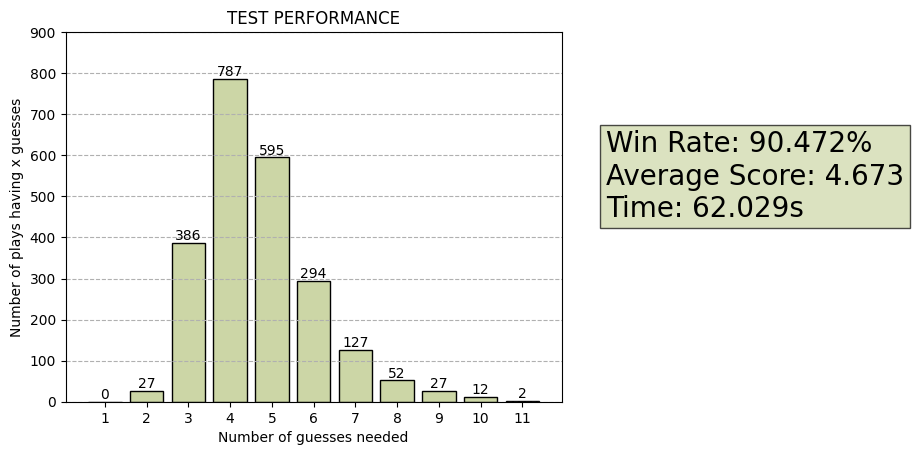

In [9]:
import sys
sys.path.append('Algorithms') #append parent folder, but small than main folder: FINAL WORDLE PROJECT
# from Wordle import *
import os
import json
from math import *

# allowed_guesses=os.path.abspath('Data/allowed_guesses.txt')
allowed_guesses="/Users/nguyenbathiem/Documents/GitHub/FINAL-WORDLE-PROJECT-2023/Data/allowed_guesses.txt"
with open(allowed_guesses,'r') as file:
    allowed_guesses=[]
    for i in file:
        allowed_guesses.append(i[:5])
        
def compute_letter_freq(allowed_guesses):
    """
    

    Parameters
    ----------
    allowed_words : list
        Contains all possible words a.k.a guess space at the beginning.

    Returns
    -------
    letter_freq : dict
        Dictionary contains frequency of each of the 26 letters, computed via allowed_words

    """
    letter_freq = dict()
    for word in allowed_guesses:
        for char in word:
            letter_freq[char] = letter_freq.get(char,0) + 1
    return letter_freq
def letter_freq_based_score(word,letter_freq):
    return sum([letter_freq[char] for char in set(word)])

def letter_freq_based_choice(still_valid_words,letter_freq):
    """
    Parameters
    ----------
    still_valid_words: list
        Contains words still possible as an answer.
    letter_freq : dict
        Dictionary contains frequency of each of the 26 letters, computed via allowed_words (original still_valid_words)

    Returns
    -------
    best_choice: str
        Word that is deemed the best choice, via summing up frequencies of different letters.

    """
    (best_choice,score) = (None,None)
    for word in still_valid_words:
        score = sum([letter_freq[char] for char in set(word)])
        if best_choice_score == None or score > best_choice_score:
            (best_choice,best_choice_score) = (word,score)
    return best_choice

def get_ranker(allowed_words,letter_freq):
    """
    Parameters
    ----------
    allowed_words : list
        Contains allowed guesses.
    Returns
    -------
    ranker : list
        Contains ~13000 tuples, whose first element is a guess, and
        second element is the entropy of that guess.

    """
    ranker = list()
    for word in allowed_words:
        ranker.append((word,letter_freq_based_score(word,letter_freq)))
    ranker.sort(key = lambda t: t[1], reverse = True)
    return ranker

# def savefile():
#     firstguess=os.path.abspath('Data/firstguesses entropy HM.json')
#     with open(firstguess,'w') as f:
#         json.dump(entropy_dict(allowed_guesses),f)
# def openfile():
#     firstguess=os.path.abspath('Data/firstguesses entropy HM.json')
#     with open(firstguess,'r') as f:
#         file=json.load(f)
#     return file
# fl=openfile()

def solution_for_test(answer:str,word_list=allowed_guesses) -> list:
    '''
    Parameters
    ----------
    answer: Five-letter actual answer.
    allowed_words: Contains ~13000 allowed guesses.
    mode: One of the seven filters: {0}, {1}, {2}, {0,1}, {0,2}, {1,2}, {0,1,2}
    --------
    Return
    -------
    tupple of guess_count and actual_guesses_list
    guesses_list: (list) list of guesses needed to reach the actual answer.
    '''
    letter_freq=compute_letter_freq(allowed_guesses)
    guesses_list=[]
    word_list=allowed_guesses
    guess=get_ranker(allowed_guesses,letter_freq)[0][0]
    while True:
        guesses_list.append(guess)
        feedback=get_feedback(guess,answer)
        if check_win(feedback):
            break
        word_list=reduce_list(guess,feedback,word_list)
        guess=get_ranker(word_list,letter_freq)[0][0]
    return guesses_list

def solution_for_WordleBot(allowed_guesses=allowed_guesses) ->list:
    '''
    This function will display the process of auto play of WordleBot
    
    ------
    Firstly, enter your answer to WordleBot try to guess
    Then press 'Enter' to look step by step
    '''
    answer = input('Enter a word for the WordleBot to guess: ').lower()
    while answer not in allowed_guesses:
        answer=input('Not a valid word - Please try again: ').lower()
    still_valid_words = allowed_guesses
    guess_board = [["_"]*5 for i in range(6)]
    feedback_board = [[None]*5 for i in range(6)]
    attempt_number = 0

    letter_freq=compute_letter_freq(allowed_guesses)
    ranker=get_ranker(allowed_guesses,letter_freq)[:10]
    while attempt_number <= 5:

        #print guess_board
        print("\n Guess #" + str(attempt_number+1))
        print("There are",len(still_valid_words),"left in the guess space.")
        
        if len(still_valid_words) > 10:
            print("By picking first highest 10 words, these are some of the words in the guess space:")
            if attempt_number >0:
                ranker = get_ranker(still_valid_words,letter_freq)[:10]
              
                        
        else:
            print("These are the words left in the guess space:")
            ranker=get_ranker(still_valid_words,letter_freq)[:10]

        print(f'Word      Score')
        for pair in ranker:
            print(f'{pair[0]}     {pair[1]:.2f}')
    
        #display guess
        guess = ranker[0][0]
        
        #update guess into guess_board
        guess_board.insert(attempt_number,list(guess))
        del guess_board[-1]

        #update feedback into feedback_board
        real_feedback = get_feedback(guess,answer)
        feedback_board.insert(attempt_number,real_feedback)
        del feedback_board[-1]

        if check_win(real_feedback) == True:
            break
        
        
        temp=reduce_list(guess, real_feedback,still_valid_words)
        still_valid_words=temp
        attempt_number += 1
        print('\n   WORDLE  ')
        print_guess_board(guess_board,feedback_board)
        print(f'Remaining possibilities: {len(still_valid_words)}')
        input('Press "Enter" to WordleBot continue playing')

        
    print('\n   WORDLE  ')
    print_guess_board(guess_board,feedback_board)
    if check_win(real_feedback):
        print('Congratulation!!')
    else:
        print("Sorry, I'm trying to be better")
    
    
def solution_for_simulationgame() -> None:
    '''
    This function simulates the real game for user easly play and use our word suggestion functionality
    
    -------
    Player try to guess to reach answer like the real game by enter their guess as usual
    If they need suggested word: Enter "yes" then choose their own guess for the next step from list of suggested word
    '''
    real_possible_answers=os.path.abspath('Data/real_possible_answers.txt')
    with open(real_possible_answers,"r") as file:
        real_possible_answers=[]
        for i in file:
            real_possible_answers.append(i[:5])
    
    answer = random.choice(real_possible_answers)
    still_valid_words = allowed_guesses
    guess_board = [["_"]*5 for i in range(6)]
    feedback_board = [[None]*5 for i in range(6)]
    attempt_number = 0
    
    letter_freq=compute_letter_freq(allowed_guesses)
    ranker=get_ranker(allowed_guesses,letter_freq)[:10]    
    
    #print guess_board
    print('\n   WORDLE  ')
    print_guess_board(guess_board,feedback_board)
    
    while attempt_number <= 5:
        change=0
        guess=input(f'Enter your {attempt_number+1}th guess\n(Enter "yes" if you need my support): ').lower()
        while guess not in still_valid_words:
            #support
            if guess =='yes':
                change=1
                print("There are",len(still_valid_words),"left in the guess space.")
                
                if len(still_valid_words) > 10:
                    print("By picking first highest 10 words, these are some of the words in the guess space:")
                    if attempt_number >0:
                        ranker = get_ranker(still_valid_words,letter_freq)[:10]
                
                else:
                    print("These are the words left in the guess space:")
                    ranker=get_ranker(still_valid_words,letter_freq)[:10]
                
                print(f'Word      Score')
                for pair in ranker:
                    print(f'{pair[0]}     {pair[1]:.2f}')
                
                        
                #official guess input
                guess=input(f'Enter your {attempt_number+1}th guess: ').lower()
                
            else:
                guess=input('Not a valid word - Please try again: ').lower()
            
            
            
        #update guess into guess_board    
        guess_board.insert(attempt_number,list(guess))
        del guess_board[-1]
        
        #update feedback into feedback_board
        real_feedback = get_feedback(guess,answer)
        feedback_board.insert(attempt_number,real_feedback)
        del feedback_board[-1]
    
        if check_win(real_feedback) == True:
            break
        
        temp=reduce_list(guess, real_feedback,still_valid_words)
        still_valid_words=temp
        attempt_number += 1
        print('\n   WORDLE  ')
        print_guess_board(guess_board,feedback_board)
        if change==1:
            print(f'Remaining possibilities: {len(still_valid_words)}')
    
    print('\n   WORDLE  ')
    print_guess_board(guess_board,feedback_board)
    if check_win(real_feedback):
        print('Congratulation!!')
    else:
        print('Game over')
        
def solution_for_realgame()->None:
    '''
    This function help gamers have guess for the next step by enter your guesses and feedback
    
    ----------
    Enter "yes" if you need support
    
    ------
    When you choose press 'Enter' \n
    Then enter all guess you entered into real game and all corresponding feedback recieved from the real game
    Ex. guess: "tares" and feedback: "00210" (0: grey, 1: yellow, 2: green)
    ------
    When you choose enter '.' \n
    This function will return some suggested word for you to continue playing on real game
    
    -------
    If you still need suggested word for the next step then Enter '.'
    
    --------
    You dont need to retype all word typed before
    When you reach your answer or lose please enter something not 'yes' to end program
    '''
    still_valid_words = allowed_guesses
    guess_board = [["_"]*5 for i in range(6)]
    feedback_board = [[None]*5 for i in range(6)]
    attempt_number = 0
    
    letter_freq=compute_letter_freq(allowed_guesses)
    ranker=get_ranker(allowed_guesses,letter_freq)[:10]    
    
    sp=input('Enter "yes" if you need my support: ')
    
    # collect inputted then reduce guess space
    while sp=='yes':
        print('\n   WORDLE  ')
        print_guess_board(guess_board,feedback_board)
        print('Enter your guesses and feedback on real game')
        mm=input('(Press "Enter" to continue add more guesses or Enter "." to suggest):  ')
        while mm!=".":
            guess = input('guess: ').lower()
            while guess not in still_valid_words:
                guess=input('Not a valid word - Please try again: ').lower()
            feedback=input('Feedback: ')
            while len(feedback) !=5:
                feedback=input('Not a valid feedback - Please try again: ')

            #update guess into guess_board  
            guess_board.insert(attempt_number,list(guess))
            del guess_board[-1]
            
            #update feedback into feedback_board
            real_feedback = [int(i) for i in str(feedback)]
            feedback_board.insert(attempt_number,real_feedback)
            del feedback_board[-1]

  
            temp = reduce_list(guess,real_feedback,still_valid_words)
            still_valid_words = temp
            mm=input('(Press "Enter" to continue or Enter "." to suggest):  ')
            attempt_number+=1
        #print suggestion    
        print('\n   WORDLE  ')
        print_guess_board(guess_board,feedback_board)
        print("There are",len(still_valid_words),"left in the guess space.")
        if len(still_valid_words) > 10:
            print("By picking first highest 10 words, these are some of the words in the guess space:")
            if attempt_number >0:
                ranker = get_ranker(still_valid_words,letter_freq)[:10]
        
        else:
            print("These are the words left in the guess space:")
            ranker=get_ranker(still_valid_words,letter_freq)[:10]
        
        print(f'Word      Score')
        for pair in ranker:
            print(f'{pair[0]}     {pair[1]:.2f}')

        
        sp=input('Enter "yes" if you need my support: ')
        
   
    


if __name__ == "__main__":
    
    # print(solution_for_test('soare'))
    # solution_for_WordleBot()
    # solution_for_simulationgame()
    # solution_for_realgame()
    
    # real_possible_answers=os.path.abspath('Data/real_possible_answers.txt')
    real_possible_answers="/Users/nguyenbathiem/Documents/GitHub/FINAL-WORDLE-PROJECT-2023/Data/real_possible_answers.txt"
    with open(real_possible_answers,"r") as file:
        real_possible_answers=[]
        for i in file:
            real_possible_answers.append(i[:5])
    TestModel(solution_for_test,real_possible_answers)

    
    
    
    
    









